In [3]:
!pip install torch

In [8]:
''' Hoew to use GPU with Pytorch? '''
import torch 

# define model
# model = MLPModel(784, 10, [1000])

# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
# input도 device에 적절하게 할당해야 함

input_X = input_X.to(device) #device에 실린 input_X가 model에 적용됨 (pred_y = model(Input_X)) #GPU사용
true_y = true_y.to(device)
input_X = input_X.squeeze()
input_X = input_X.view(-1, 784)

pred_y = model(input_X) #input_X = input_X.to(device) 를 받음  #GPU사용


# GPU에 할당할지, CPU에 할당할지
# 1) input: GPU -> output(true_y): CPU
# 2) input: GPU -> output(true_y): GPU  -> output에 대한 계산이 iterantion 없이 일어나기 때문에 1)보다 빠르게 loss를 계산 할 수 있음

# 나아가 loss가 dependence한 경우도 있기 때문에 to(device)를 사용하여 criterion을 device에 보내주도록 한다. 이럴 경우 pred_y, true_y, loss, backpropagation 등 전체적으로 선택한 device 예컨대, GPU에서 모두 계산해준다.
criterion = nm.MSE()
criterion.to(device)

In [4]:
'''  MNIST Digit Recogntion '''

!pip install -q torch==1.7.0 torchvision
import torch
print(torch.__version__)

1.7.0+cu101


In [5]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

**1. Data Preparation**

In [6]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
50000 10000 10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- Inspecting Dataset

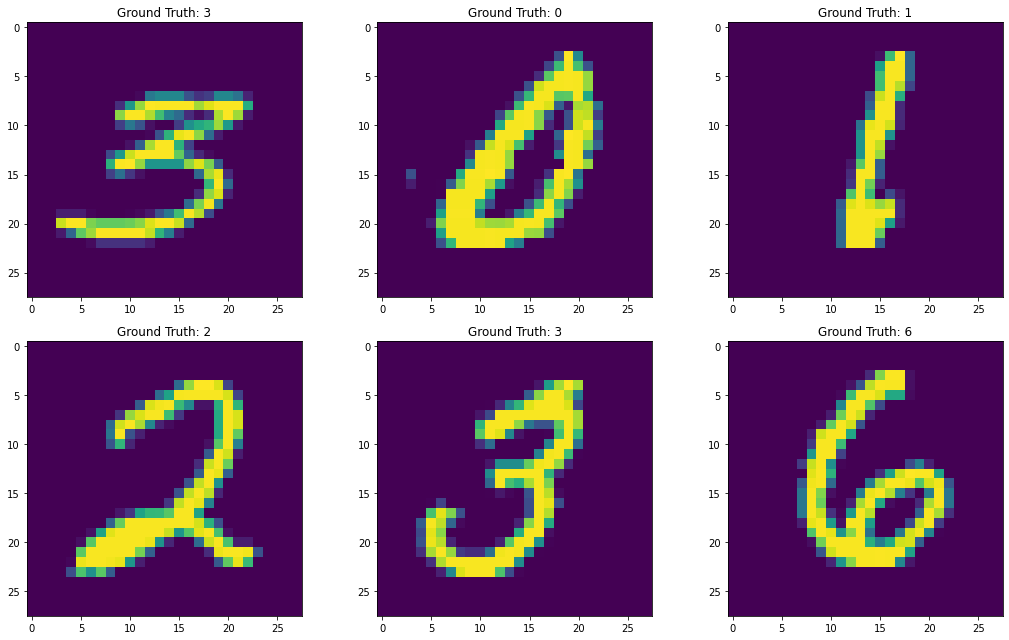

In [7]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='viridis', interpolation = 'none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

**2. Model Architecture**

In [8]:
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(in_features=784, out_features=10, bias=True)

  def forward(self, x):
    x = self.linear(x)
    return(x)

**3. Cost Function Define (Loss Function Define)**

In [9]:
cls_loss = nn.CrossEntropyLoss()

**4. Train & Evalution**

In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [11]:
# ====== Construct Model ===== #
model = LinearModel()
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of 7850 parameters


In [12]:
# ===== Construct Optimizer ===== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):

  # ===== Train =====#
  train_loss = 0
  model.train()
  optimizer.zero_grad()

  for input_X, true_y in train_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.detach().numpy()
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)


  # ===== Validation ===== #
  val_loss = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in val_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    val_loss += loss.detach().numpy()
  val_loss = val_loss / len(val_loader)
  list_val_loss.append(val_loss)

  # ====== Evaluation ===== #
  correct = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in test_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
    correct += pred_y.eq(true_y).sum()

  acc = correct.numpy() / len(test_loader.dataset)
  list_acc.append(acc)
  list_acc_epoch.append(i)

  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Epoch: 0, Train Loss: 1.4827326583435467, Val Loss: 2.2917920554151077, Test Acc: 88.29%
Epoch: 1, Train Loss: 1.774480637610721, Val Loss: 1.6722870685248898, Test Acc: 88.35%
Epoch: 2, Train Loss: 1.3960550687349667, Val Loss: 1.8562887767197187, Test Acc: 87.02%
Epoch: 3, Train Loss: 1.5116360029753517, Val Loss: 2.3321373470221896, Test Acc: 84.69%
Epoch: 4, Train Loss: 1.7329905126100915, Val Loss: 2.6090019753650773, Test Acc: 85.99%
Epoch: 5, Train Loss: 1.72752349349239, Val Loss: 2.7251500999437104, Test Acc: 84.54%
Epoch: 6, Train Loss: 1.791648937994257, Val Loss: 2.7131081640343124, Test Acc: 85.71%
Epoch: 7, Train Loss: 1.8340954807255885, Val Loss: 2.639340644089293, Test Acc: 86.00999999999999%
Epoch: 8, Train Loss: 1.9125172253459921, Val Loss: 2.8528043718277654, Test Acc: 85.15%
Epoch: 9, Train Loss: 1.914618202182643, Val Loss: 2.8770493186915975, Test Acc: 85.97%
Epoch: 10, Train Loss: 1.8894117848418863, Val Loss: 2.7774002529397794, Test Acc: 85.75%
Epoch: 11, Tra

**5. Report Experiment**

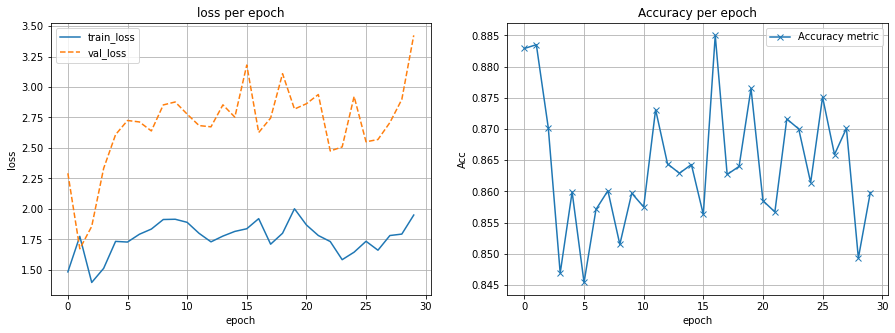

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

# ===== Loss Fluctutaion ===== #
ax1 = fig.add_subplot(1,2,1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('loss per epoch')

# ===== Metric Fluctuation ===== #
ax2 = fig.add_subplot(1,2,2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('Accuracy per epoch')

plt.show()



In [14]:
import time

In [16]:
# ====== Construct Model ===== #
model = LinearModel()
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ===== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
  ts = time.time()

  # ===== Train =====#
  train_loss = 0
  model.train()
  optimizer.zero_grad()

  for input_X, true_y in train_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.detach().numpy()
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)


  # ===== Validation ===== #
  val_loss = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in val_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    val_loss += loss.detach().numpy()
  val_loss = val_loss / len(val_loader)
  list_val_loss.append(val_loss)

  # ====== Evaluation ===== #
  correct = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in test_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
    correct += pred_y.eq(true_y).sum()

  acc = correct.numpy() / len(test_loader.dataset)
  list_acc.append(acc)
  list_acc_epoch.append(i)

  te = time.time()
  
  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.1f}'.format(i, train_loss, val_loss, acc*100, te-ts))

Epoch: 0, Train Loss: 1.8228221877151742, Val Loss: 2.6089789516563657, Test Acc: 86.33999999999999%, 11.7
Epoch: 1, Train Loss: 1.81707479730439, Val Loss: 2.692081595642488, Test Acc: 87.22%, 11.7
Epoch: 2, Train Loss: 1.7011558582715671, Val Loss: 2.755252518985845, Test Acc: 84.45%, 11.6
Epoch: 3, Train Loss: 1.7750091351511534, Val Loss: 2.5699827509778963, Test Acc: 86.47%, 11.6
Epoch: 4, Train Loss: 1.6331980906026748, Val Loss: 2.4834140918257988, Test Acc: 86.28%, 11.6
Epoch: 5, Train Loss: 1.711712873652768, Val Loss: 2.7468334813661213, Test Acc: 86.14%, 11.6
Epoch: 6, Train Loss: 1.6231087238130057, Val Loss: 2.425049752826822, Test Acc: 86.02%, 11.5
Epoch: 7, Train Loss: 1.570185009856968, Val Loss: 2.4582568180711966, Test Acc: 87.13%, 11.4
Epoch: 8, Train Loss: 1.4350029616366566, Val Loss: 2.401593839914738, Test Acc: 84.99%, 11.4
Epoch: 9, Train Loss: 1.61149569202567, Val Loss: 2.670333812484824, Test Acc: 86.56%, 11.7
Epoch: 10, Train Loss: 1.643975405894277, Val Los

In [17]:
# cuda 설치와 사용 가능
print(torch.cuda.is_available())

True


In [21]:
# ====== Construct Model ===== #
model = LinearModel()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ===== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
  ts = time.time()

  # ===== Train =====#
  train_loss = 0
  model.train()
  optimizer.zero_grad()

  for input_X, true_y in train_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    input_X = input_X.to(device)
    true_y = true_y.to(device)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()
    # train_loss += loss.detach().numpy() -> TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
    train_loss += loss.item()
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)


  # ===== Validation ===== #
  val_loss = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in val_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    
    input_X = input_X.to(device)
    true_y = true_y.to(device)
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    # val_loss += loss.detach().numpy() 
    val_loss += loss.item()
  val_loss = val_loss / len(val_loader)
  list_val_loss.append(val_loss)

  # ====== Evaluation ===== #
  correct = 0
  model.eval()
  optimizer.zero_grad()

  for input_X, true_y in test_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    input_X = input_X.to(device)
    true_y = true_y.to(device)
    pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
    correct += pred_y.eq(true_y).sum()

  acc = correct.item() / len(test_loader.dataset)
  list_acc.append(acc)
  list_acc_epoch.append(i)

  te = time.time()
  
  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.1f}'.format(i, train_loss, val_loss, acc*100, te-ts))

Number of 7850 parameters
Epoch: 0, Train Loss: 1.5061880750271974, Val Loss: 2.2034970376686935, Test Acc: 89.55%, 12.1
Epoch: 1, Train Loss: 1.771772486169625, Val Loss: 1.7213360521517977, Test Acc: 88.3%, 12.2
Epoch: 2, Train Loss: 1.4286648356319998, Val Loss: 1.9677228122195112, Test Acc: 86.02%, 12.1
Epoch: 3, Train Loss: 1.4909293793351448, Val Loss: 1.741489966816171, Test Acc: 87.48%, 12.0
Epoch: 4, Train Loss: 1.18726413912328, Val Loss: 1.5013054448763221, Test Acc: 88.02%, 12.1
Epoch: 5, Train Loss: 1.1639578598539542, Val Loss: 1.7458881627977532, Test Acc: 86.81%, 11.8
Epoch: 6, Train Loss: 1.3365087099468616, Val Loss: 2.1416317643244054, Test Acc: 85.9%, 11.7
Epoch: 7, Train Loss: 1.509794414881855, Val Loss: 2.0245913851864725, Test Acc: 87.96000000000001%, 11.6
Epoch: 8, Train Loss: 1.3817194848109389, Val Loss: 1.9575311152052275, Test Acc: 85.02%, 11.6
Epoch: 9, Train Loss: 1.361900316213098, Val Loss: 2.311063880218735, Test Acc: 85.79%, 11.4
Epoch: 10, Train Loss